##### Tutorial on making the plot Interactive #####
https://saturncloud.io/blog/python-matplotlib-make-3d-plot-interactive-in-jupyter-notebook/#:~:text=To%20make%20our%203D%20plot,using%20our%20mouse%20or%20trackpad. 

In [1]:
# %matplotlib notebook
%matplotlib widget
# %matplotlib inline
# I didn't have the line "%matplotlib inline" and then the plots weren't showing 

# What's really important is %matplotlib widget cause that's how I was able to make it interactive

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import numpy as np

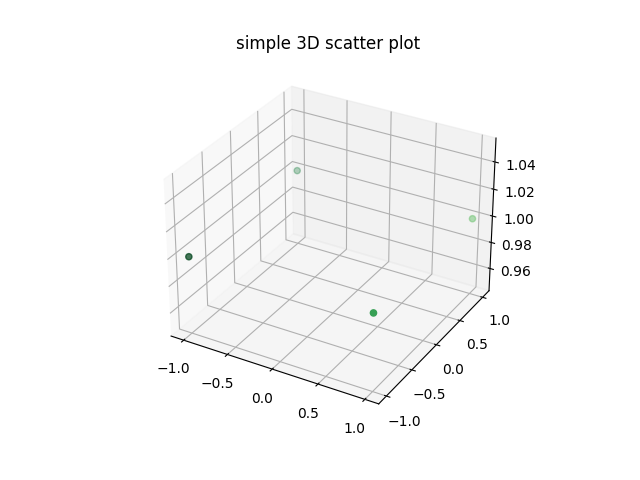

In [3]:
# Creating dataset
square = np.array([[1, 1, 1], [1, -1, 1], [-1, 1, 1], [-1, -1, 1]])

# Creating figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
 
# Create a gradient for the colorsx
num_points = square.shape[0]
gradient = np.linspace(0.5, 1, num_points)
colors = plt.cm.Greens(gradient)

# Creating plot
ax.scatter(square[:, 0], square[:, 1], square[:, 2], c=colors)
plt.title("simple 3D scatter plot")
 
# show plot
plt.show()

(500,)
(500, 4)


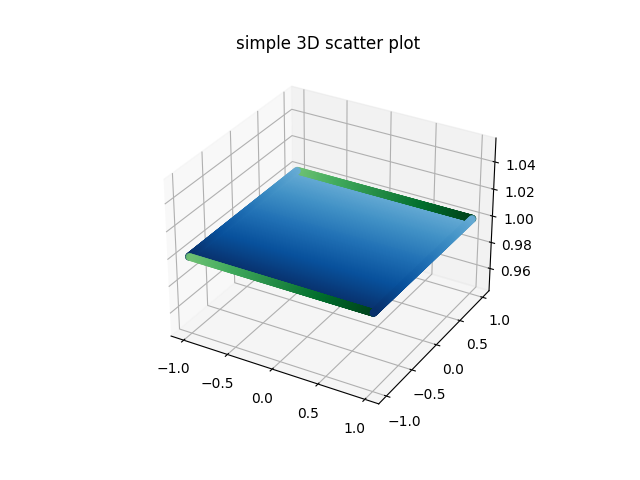

In [4]:
# Create green dots for left side of line
num_dots = 500

left_green = np.linspace(-1, 1, num_dots).reshape((-1, 1)) # x values
left_neg_ones = -1*np.ones((left_green.shape))
left_ones =  np.ones(left_green.shape)
left_green_points = np.concatenate((left_green, left_neg_ones, left_ones), axis=1)


right_green = np.linspace(-1, 1, num_dots).reshape((-1, 1))
right_neg_ones = np.ones((right_green.shape))
right_ones =  np.ones(right_green.shape)
right_green_points = np.concatenate((right_green, right_neg_ones, right_ones), axis=1)

# Creating figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

gradient = np.linspace(0.5, 1, num_dots)
green_colors = plt.cm.Greens(gradient)
blue_colors = plt.cm.Blues(gradient)

# Creating plot
ax.scatter(left_green_points[:, 0], left_green_points[:, 1], left_green_points[:, 2], c=green_colors)
print(left_green_points[:, 0].shape)
print(green_colors.shape)
ax.scatter(right_green_points[:, 0], right_green_points[:, 1], right_green_points[:, 2], c=green_colors)
for i in range(left_green.shape[0]):
    ax.plot([left_green_points[i, 0], right_green_points[i, 0]], [left_green_points[i, 1], right_green_points[i, 1]], [left_green_points[i, 2], right_green_points[i, 2]], c=green_colors[i], linewidth=1)


# Now we rotate left_green_points by 90deg
rotation_matrix = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
left_blue_points = np.matmul(left_green_points, rotation_matrix)
right_blue_points = np.matmul(right_green_points, rotation_matrix)
ax.scatter(left_blue_points[:, 0], left_blue_points[:, 1], left_blue_points[:, 2], c=blue_colors)
ax.scatter(right_blue_points[:, 0], right_blue_points[:, 1], right_blue_points[:, 2], c=blue_colors)
for i in range(left_green.shape[0]):
    ax.plot([left_blue_points[i, 0], right_blue_points[i, 0]], [left_blue_points[i, 1], right_blue_points[i, 1]], [left_blue_points[i, 2], right_blue_points[i, 2]], c=blue_colors[i], linewidth=1)
    # print("blue_colors: ", blue_colors[i])
# print(left_blue_points)

# show plot
plt.title("simple 3D scatter plot")
plt.show()

# TODO: Draw a line between all of these points using a for loop

# print(left_green_points)



#### Attempt 2 at combining colors ####

X shape:  (100, 100)
Y shape:  (100, 100)
combined data shape:  (100, 100)
color:  (100, 100, 4)
x_new.shape:  (10000,)
color_new.shape:  (10000, 4)


C:\Users\Joshua\AppData\Local\Temp\ipykernel_20440\665103609.py:42: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(x_new, y_new, c=color_new, cmap=custom_cmap, s=50, marker='o')


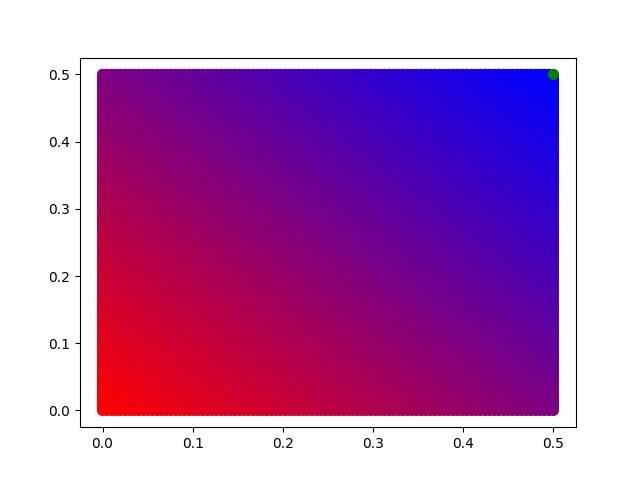

In [17]:
# Code Adatped from AI

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import normalize

# Create a custom colormap
cmap_colors = [(0, 'red'), (1, 'blue'), (1, 'green')]  # Colors for the combined dimension
custom_cmap = LinearSegmentedColormap.from_list('custom', cmap_colors)

# Create a 2D grid of values for both dimensions
numDimensions = 2
x = np.linspace(0, 1/numDimensions, 100)
y = np.linspace(0, 1/numDimensions, 100)
X, Y = np.meshgrid(x, y)
print("X shape: ", X.shape)
print("Y shape: ", Y.shape)

# Combine data for both dimensions into a single variable
combined_data = X + Y  # You can use a different combination as needed
print("combined data shape: ", combined_data.shape)
# print(combined_data)
# combined_data = normalize(combined_data, norm='l2', axis=0)
# print(combined_data)
# Apply the custom colormap to the combined data
color = custom_cmap(combined_data)
# color = np.delete(color, -1, axis=-1)
print("color: ", color.shape)
# print(color)
# Create a figure and axis
fig, ax = plt.subplots()

# reshape x and y to match what is expected
x_new = X.reshape((-1,))
y_new = Y.reshape((-1,))
color_new = color.reshape((-1, 4))
print("x_new.shape: ", x_new.shape)
print("color_new.shape: ", color_new.shape)

# Plot the 2D grid with the colormap representing both dimensions
sc = ax.scatter(x_new, y_new, c=color_new, cmap=custom_cmap, s=50, marker='o')
# cbar = plt.colorbar(sc, ax=ax)
# cbar.set_label('Color Gradient')

# Show the plot
plt.show()

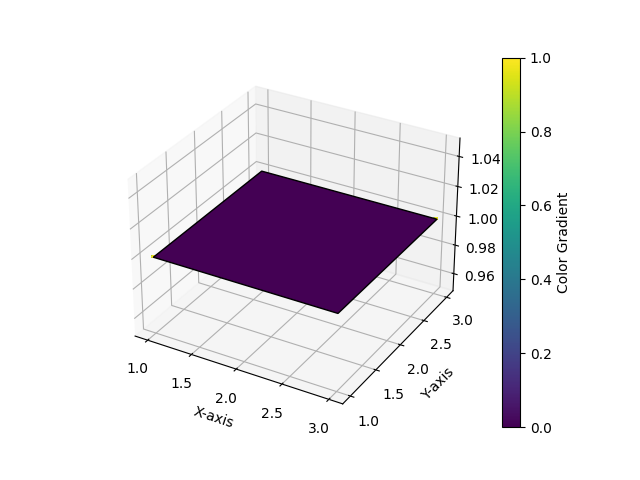

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Define the coplanar points
points = np.array([[1, 1, 1], [1, 3, 1], [3, 3, 1], [3, 1, 1]])

# Create a grid of points within the plane
x = np.linspace(1, 3, 100)
y = np.linspace(1, 3, 100)
X, Y = np.meshgrid(x, y)
Z = np.ones_like(X)  # All points have the same z-coordinate

# Create a color gradient for the plane
colors = np.linspace(0, 1, 100)

# Create a figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the grid points with the color gradient
for i in range(100):
    ax.plot(x, y, Z[i], color=plt.cm.viridis(colors[i]))

# Define the vertices of the plane polygon
vertices = [list(points[0]), list(points[1]), list(points[2]), list(points[3])]

# Create the Poly3DCollection
plane = Poly3DCollection([vertices], cmap='viridis', edgecolor='k')
plane.set_array(colors)

# Add the plane to the plot
ax.add_collection3d(plane)

# Set labels for the axes
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Add a colorbar
cbar = fig.colorbar(plane, ax=ax)
cbar.set_label('Color Gradient')

plt.show()


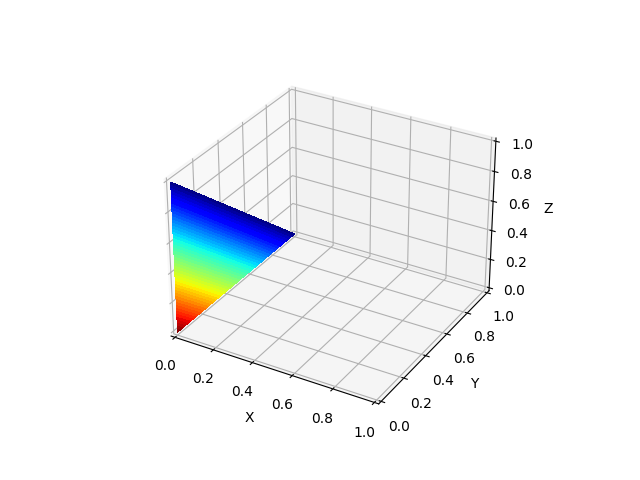

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

X, Y = np.meshgrid(np.linspace(0,1), np.linspace(0,1)) 
Z = 1.-X-Y
Z[Z<0] = 0
# for i in range(X.shape[0]):
#     print(X[i])
# print(X)
# print("=======")
# print(Y)
# print("=======")
# print(Z)
cset = ax.contourf(X, Y, Z, zdir='x', levels=np.linspace(0,1),offset=0, cmap=plt.cm.jet)
ax.set_xlabel('X')
ax.set_xlim(0, 1)
ax.set_ylabel('Y')
ax.set_ylim(0,1)
ax.set_zlabel('Z')
ax.set_zlim(0,1)    
plt.show()

In [8]:
# Define coordinate vectors (1D arrays)
x = np.array([0, 1, 2, 3])
y = np.array([10, 20, 30])

# Use np.meshgrid to create coordinate matrices
X, Y = np.meshgrid(x, y)
print("X (Coordinate Matrix for X):")
print(X)
print("Y (Coordinate Matrix for Y):")
print(Y)

X (Coordinate Matrix for X):
[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]
Y (Coordinate Matrix for Y):
[[10 10 10 10]
 [20 20 20 20]
 [30 30 30 30]]


### Below is Isaac's code ###

blended_colors:  (500, 4)
(500, 1)
(500, 1)


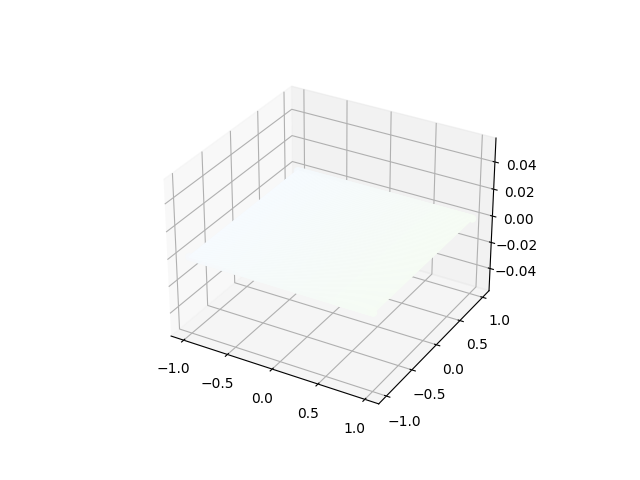

In [9]:
# Create green dots for left side of line
num_dots = 500

left_green = np.linspace(-1, 1, num_dots).reshape((-1, 1)) # x values
left_neg_ones = -1*np.ones((left_green.shape))
left_zeros =  np.zeros(left_green.shape)
left_green_points = np.concatenate((left_green, left_neg_ones, left_zeros), axis=1)

# Create green dots for the right side of line
right_green = np.linspace(-1, 1, num_dots).reshape((-1, 1))
right_ones = np.ones((right_green.shape))
right_zeros =  np.zeros(right_green.shape)
right_green_points = np.concatenate((right_green, right_ones, right_zeros), axis=1)

# Creating 3D background figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

interp_factor = np.linspace(0, 1, num_dots)
blended_colors = interp_factor[:, np.newaxis] * plt.cm.Greens(1) + (1 - interp_factor[:, np.newaxis]) * plt.cm.Blues(1)

print("blended_colors: ", blended_colors.shape)
print(left_green.shape)
print(right_green.shape)

ax.scatter(left_green_points[:, 0], left_green_points[:, 1], left_green_points[:, 2], c=blended_colors)
ax.scatter(right_green_points[:, 0], right_green_points[:, 1], right_green_points[:, 2], c=blended_colors)

for i in range(left_green.shape[0]):
    ax.plot([left_green_points[i, 0], right_green_points[i, 0]], 
            [left_green_points[i, 1], right_green_points[i, 1]], 
            [left_green_points[i, 2], right_green_points[i, 2]], 
            c=blended_colors[i], linewidth=1)

# # Create the gradients separately
# gradient = np.linspace(0.5, 1, num_dots)
# green_colors = plt.cm.Greens(gradient)
# blue_colors = plt.cm.Blues(gradient)

# # Creating plot for the green gradient
# ax.scatter(left_green_points[:, 0], left_green_points[:, 1], left_green_points[:, 2], c=green_colors)
# ax.scatter(right_green_points[:, 0], right_green_points[:, 1], right_green_points[:, 2], c=green_colors)
# for i in range(left_green.shape[0]):
#     ax.plot([left_green_points[i, 0], right_green_points[i, 0]], [left_green_points[i, 1], right_green_points[i, 1]], [left_green_points[i, 2], right_green_points[i, 2]], c=green_colors[i], linewidth=1)

# # # Now we rotate left_green_points by 90deg to obtain blue gradient
# rotation_matrix = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

# left_blue_points = np.dot(left_green_points, rotation_matrix)
# right_blue_points = np.dot(right_green_points, rotation_matrix)

# ax.scatter(left_blue_points[:, 0], left_blue_points[:, 1], left_blue_points[:, 2], c=blue_colors)
# ax.scatter(right_blue_points[:, 0], right_blue_points[:, 1], right_blue_points[:, 2], c=blue_colors)

# for i in range(left_blue_points.shape[0]):
#     ax.plot([left_blue_points[i, 0], right_blue_points[i, 0]], [left_blue_points[i, 1], right_blue_points[i, 1]], 
#             [left_blue_points[i, 2], right_blue_points[i, 2]], c=blue_colors[i], linewidth=1)

#### Homography Explained With Code ####
https://docs.opencv.org/4.x/d9/dab/tutorial_homography.html 

#### Youtube Video Explaining Homography ####

- 2x2 Image Transformations: https://youtu.be/K2XLXlyPqCA 

- 3x3 Image Transformations: https://www.youtube.com/watch?v=B8kMB6Hv2eI

- Homography: https://www.youtube.com/watch?v=l_qjO4cM74o 